# Experiment 02: BCI

This experiment uses a Brain Computer Interface dataset. The purpose is to try and predict when the participant is paying attention. The dataset consists of recordings from a number of electrodes placed over the scalp.

In [43]:
import os,sys
import numpy as np
import pandas as pd
from copy import deepcopy
from tqdm import tqdm_notebook, tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import roc_auc_score,accuracy_score, precision_score, recall_score, f1_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBModel
import json

from libs.loaders import load_bci
from libs.timer import Timer
from libs.utils import get_number_processors

import pkg_resources

from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models.sources import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.io import export_png
from PIL import Image

print("System version: {}".format(sys.version))
print("XGBoost version: {}".format(pkg_resources.get_distribution('xgboost').version))
print("LightGBM version: {}".format(pkg_resources.get_distribution('lightgbm').version))

%load_ext autoreload
%autoreload 2



System version: 3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
XGBoost version: 0.6
LightGBM version: 0.2
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
output_notebook()

Loading BokehJS ...

## XGBoost vs LightGBM benchmark

We will compare both libraries on speed and preformance.

In [3]:
number_processors = get_number_processors()
print(number_processors)

20


Below we define the modeling pipelines for our two classifiers.

In [4]:
pipeline_steps = [('scale', StandardScaler())]
continuous_pipeline = Pipeline(steps=pipeline_steps)

In [5]:
featurisers = [('continuous', continuous_pipeline)]

In [6]:
xgb_clf_pipeline = Pipeline(steps=[('features', FeatureUnion(featurisers)),
                                          ('clf', XGBClassifier(max_depth=3, 
                                                                learning_rate=0.1, 
                                                                scale_pos_weight=2,
                                                                n_estimators=100,
                                                                gamma=0.1,
                                                                min_child_weight=1,
                                                                reg_lambda=1,
                                                                subsample=1,
                                                                nthread=number_processors
                                                                ))])

In [7]:
xgb_hist_clf_pipeline = Pipeline(steps=[('features', FeatureUnion(featurisers)),
                                          ('clf', XGBClassifier(max_depth=0, 
                                                                learning_rate=0.1, 
                                                                scale_pos_weight=2,
                                                                n_estimators=100,
                                                                gamma=0.1,
                                                                min_child_weight=1,
                                                                reg_lambda=1,
                                                                subsample=1,
                                                                max_leaves=2**3,
                                                                grow_policy='lossguide',
                                                                tree_method='hist',
                                                                nthread=number_processors
                                                                ))])

In [8]:
lgbm_clf_pipeline = Pipeline(steps=[('features', FeatureUnion(featurisers)),
                                          ('clf', LGBMClassifier(num_leaves=2**3, 
                                                                learning_rate=0.1, 
                                                                scale_pos_weight=2,
                                                                n_estimators=100,
                                                                min_split_gain=0.1,
                                                                min_child_weight=1,
                                                                reg_lambda=1,
                                                                subsample=1,
                                                                nthread=number_processors
                                                                ))])

The dataset has been preprepared by extracting 800ms epochs from each channel. The data was then lowpass filtered at 18Hz and downsampled by a factor of 6. This results is a feature vector of


In [9]:
%%time
X, y, X_test, y_test = load_bci()

INFO:libs.loaders:MOUNT_POINT not found in environment. Defaulting to /fileshare


CPU times: user 3.18 s, sys: 580 ms, total: 3.76 s
Wall time: 20.9 s


In [10]:
metrics_dict = {
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'AUC': roc_auc_score,
    'F1': f1_score,
}

def classification_metrics(metrics, y_true, y_pred):
    return {metric_name:metric(y_true, y_pred) for metric_name, metric in metrics.items()}

In [11]:
results_dict = dict()

### XGBoost

In [12]:
with Timer() as t_train:
    xgb_clf_pipeline.fit(np.concatenate(X),np.concatenate(y))

In [13]:
with Timer() as t_test:
    y_pred = xgb_clf_pipeline.predict(np.concatenate(X_test))

In [14]:
results_dict['xgb']={
    'train_time': t_train.interval,
    'test_time': t_test.interval,
    'performance': classification_metrics(metrics_dict, 
                                          np.concatenate(y_test), 
                                          y_pred) 
}

In [15]:
with Timer() as t_train:
    xgb_hist_clf_pipeline.fit(np.concatenate(X),np.concatenate(y))

In [16]:
with Timer() as t_test:
    y_pred = xgb_hist_clf_pipeline.predict(np.concatenate(X_test))

In [17]:
results_dict['xgb_hist']={
    'train_time': t_train.interval,
    'test_time': t_test.interval,
    'performance': classification_metrics(metrics_dict, 
                                          np.concatenate(y_test), 
                                          y_pred) 
}

### LightGBM

In [18]:
with Timer() as t_train:
    lgbm_clf_pipeline.fit(np.concatenate(X),np.concatenate(y))

In [19]:
with Timer() as t_test:
    y_pred = lgbm_clf_pipeline.predict(np.concatenate(X_test))

In [20]:
results_dict['lgbm']={
    'train_time': t_train.interval,
    'test_time': t_test.interval,
    'performance': classification_metrics(metrics_dict, 
                                          np.concatenate(y_test), 
                                          y_pred) 
}

In [21]:
# Results
print(json.dumps(results_dict, indent=4, sort_keys=True))

{
    "lgbm": {
        "performance": {
            "AUC": 0.5348626373626374,
            "Accuracy": 0.8802275008364001,
            "F1": 0.13734939759036147,
            "Precision": 0.5588235294117647,
            "Recall": 0.0782967032967033
        },
        "test_time": 0.20288882195018232,
        "train_time": 6.441622233949602
    },
    "xgb": {
        "performance": {
            "AUC": 0.5277435897435897,
            "Accuracy": 0.8812311809969889,
            "F1": 0.11027568922305765,
            "Precision": 0.6285714285714286,
            "Recall": 0.06043956043956044
        },
        "test_time": 0.31435969995800406,
        "train_time": 13.533113401965238
    },
    "xgb_hist": {
        "performance": {
            "AUC": 0.536521978021978,
            "Accuracy": 0.8810639009702241,
            "F1": 0.14234016887816647,
            "Precision": 0.5841584158415841,
            "Recall": 0.08104395604395605
        },
        "test_time": 0.3082847240148112,


## Concept Drift
Concept drift can occur across many domains and can be caused by many factors such as sensor drift, seasonality, regime change, etc. One of the ways to combat this is by retraining. If the cause for the drift is observable then it can be incorporated into the model. In this specific instance the cause for the drift is an increase in the impedance in the electrodes, fatigue as well as a number of other factors. These are not observable in the dataset so we will have to retrain the model at regular intervals and observe the difference in performance. This constant retraining can be costly especially with large datasets. Below we will compare XGBoost and LightGBM in a naive retraining scenario.

In [22]:
def _predict(model, X_test, y_test, auc_list, interval_list):
    with Timer() as t:
        y_pred = model.predict_proba(X_test)
        auc_list.append(roc_auc_score(y_test, y_pred[:, 1]))
    interval_list.append(t.interval)

In [23]:
def run_train_retrain_comparison(model, X, y, X_test, y_test):
    retrain_model = deepcopy(model)
    historical_X = deepcopy(X.tolist())
    historical_y = deepcopy(y.tolist())
    train_auc = list()
    retrain_auc = list()
    test_interval = list()
    retrain_test_interval = list()
    retrain_interval = list()
    
    for X_test_run, y_test_run in  tqdm_notebook(zip(X_test, y_test), total=len(y_test)):
        prev_model = deepcopy(retrain_model)
        
        _predict(model, X_test_run, y_test_run, train_auc, test_interval)
        _predict(retrain_model, X_test_run, y_test_run, retrain_auc, retrain_test_interval)
        
        historical_X.append(X_test_run)
        historical_y.append(y_test_run)

        new_train_X  = np.concatenate(historical_X)
        with Timer() as t:
            retrain_model.fit(new_train_X, np.concatenate(historical_y))
        retrain_interval.append(t.interval)    
        
    return pd.DataFrame({
        'Test interval':test_interval,
        'Retrain Test interval':retrain_test_interval,
        'Retrain interval':retrain_interval,
        'Train AUC':train_auc,
        'Retrain AUC':retrain_auc
    })

In [24]:
df = run_train_retrain_comparison(xgb_clf_pipeline, X, y, X_test, y_test)

In [25]:
retrain_results_dict = dict()

In [26]:
retrain_results_dict['xgb'] = df

In [27]:
df = run_train_retrain_comparison(lgbm_clf_pipeline, X, y, X_test, y_test)

In [28]:
retrain_results_dict['lgbm'] = df

In [29]:
data_cds = (retrain_results_dict['xgb'][['Train AUC', 'Retrain AUC']].rolling(window=10)
                                                                     .mean()
                                                                     .dropna()
                                                                     .pipe(ColumnDataSource))

In [30]:
# XGB Retrain Results
p = figure(y_axis_label='AUC', plot_width=700, plot_height=350, tools="pan,wheel_zoom,box_zoom,reset")
l1 = p.line('index', 'Train AUC', legend=' Train AUC', line_color="#5975a4", source=data_cds, line_width=6, line_cap="round")
p.circle('index', 'Train AUC', fill_color="white", size=6, line_width=1.5, line_color="#5975a4", source=data_cds)
p.line('index', 'Retrain AUC', legend=' Retrain AUC', line_color="#a1bae3", source=data_cds, line_width=6, line_cap="round")
p.circle('index', 'Retrain AUC',  fill_color="white", size=6, line_width=1.5, line_color="#a1bae3", source=data_cds)
l1_hover = HoverTool(renderers=[l1], tooltips=[( 'Train AUC',  '@{Train AUC}{0.4f}' ), ( 'Retrain AUC',  '@{Retrain AUC}{0.4f}' )], mode='vline')
p.add_tools(l1_hover)
show(p)

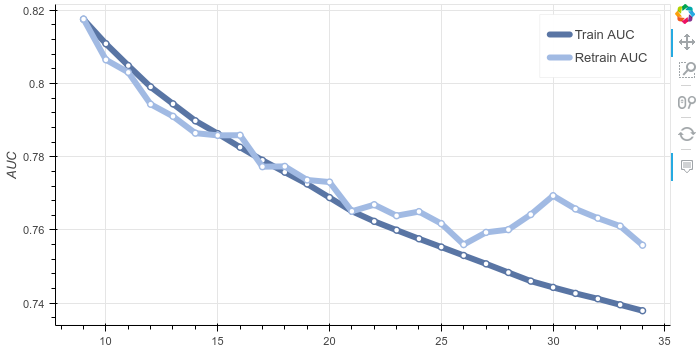

In [52]:
# So that the plots are visible in github
export_png(p, filename='xgb_bci_train_retrain.png')
Image.open('xgb_bci_train_retrain.png')

In [45]:
from bokeh.io import export_svgs

In [46]:
p.output_backend = "svg"
export_svgs(p, filename="plot.svg")

['plot.svg']

In [49]:
!ls

01_airline-GPU.ipynb	 bci_time.png		   Retraining-Copy1.ipynb
01_airline.ipynb	 ghostdriver.log	   Retraining.ipynb
02_BCI.ipynb		 __init__.py		   Salaries.csv
03_football.ipynb	 lgbm_retrain_results.svg  Salaries.csv.zip
04_PlanetKaggle.ipynb	 libs			   XGBoostvsLightGBM.ipynb
05_FraudDetection.ipynb  plot.svg		   xgb_retrain_results.svg
06_HIGGS.ipynb		 __pycache__		   xgb_vs_lgbm_retrain_time.svg


In [50]:
from IPython.display import SVG, display

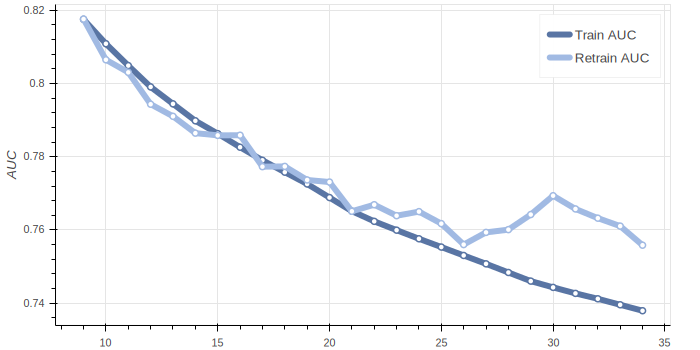

In [51]:
display(SVG('plot.svg'))

In [48]:
Image.open('plot.svg')

OSError: cannot identify image file 'plot.svg'

Overall we can see that retraining does seem to help a bit. Ofcourse the retraining done here is naive with no consideration that later samples may also contain more noise. 

In [202]:
data_cds = (retrain_results_dict['lgbm'][['Train AUC', 'Retrain AUC']].rolling(window=10)
                                                                      .mean()
                                                                      .dropna()
                                                                      .pipe(ColumnDataSource))

In [203]:
# LGBM Retrain Results
p = figure(y_axis_label='AUC', plot_width=700, plot_height=350, tools="pan,wheel_zoom,box_zoom,reset")
l1 = p.line('index', 'Train AUC', legend=' Train AUC', line_color='#5f9e6f', source=data_cds, line_width=6, line_cap="round")
p.circle('index', 'Train AUC', fill_color="white", size=6, line_width=1.5, line_color="#5975a4", source=data_cds)
p.line('index', 'Retrain AUC', legend=' Retrain AUC', line_color='#a2cfae', source=data_cds, line_width=6, line_cap="round")
p.circle('index', 'Retrain AUC',  fill_color="white", size=6, line_width=1.5, line_color="#a1bae3", source=data_cds)
l1_hover = HoverTool(renderers=[l1], tooltips=[( 'Train AUC',  '@{Train AUC}{0.4f}' ), ( 'Retrain AUC',  '@{Retrain AUC}{0.4f}' )], mode='vline')
p.add_tools(l1_hover)
show(p)

Retrainig does also seem to improve the results for the LightGBM model.

In [205]:
xgb_series = retrain_results_dict['xgb'][['Retrain Test interval', 'Retrain interval', 'Test interval']].sum()
lgbm_series = retrain_results_dict['lgbm'][['Retrain Test interval', 'Retrain interval', 'Test interval']].sum()

In [214]:
t_res = pd.DataFrame([['XGBoost', xgb_series['Retrain interval']/60],
              ['LightGBM', lgbm_series['Retrain interval']/60]], columns=['Model', 'Time(m)']).assign(color=["#5975a4", "#5f9e6f"])

In [215]:
t_cds = ColumnDataSource(t_res)

In [228]:
# XGB vs LGBM Retrain Time
p = figure(plot_width=300, plot_height=500, x_range=t_res['Model'].tolist(), y_axis_label='Time (minutes)')
p.vbar(x='Model', width=0.8, bottom=0, top='Time(m)', color="color", source=t_cds)
show(p)

LightGBM seems to be almost twice as fast as XGBoost and offer similar performance. In general, leaf-wise algorithms are more efficient and converge faster than depth-wise. However, it can easily over-fit when the data is small or the number of leaves is too high.